# MASTER - Notebook 2
### Matteo Grazioso 884055

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from pandas import Timestamp
import json
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [2]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Find all txt files in the data folder
txt_files = mf.find_txt_files("data/processed")

# Choose a dataset from the list of txt files
selected_dataset = mf.choose_dataset(txt_files)

if selected_dataset:
    print(f"You selected the dataset {selected_dataset}")
else:
    print("No dataset selected.")

path  = selected_dataset

The following TXT files were found:
1. data/processed/dataset_cleaned_esportazioneCompleta.txt
2. data/processed/dataset_cleaned_tempexport.txt
3. data/processed/dataset_cleaned_validazioni.txt
4. data/processed/old smaller/dataset_cleaned_esportazioneCompleta.txt
5. data/processed/old smaller/dataset_cleaned_validazioni.txt
You selected the dataset data/processed/dataset_cleaned_esportazioneCompleta.txt


In [4]:
# The file contains the data of the validation of tickets in the city of public transport of Venice.
# The file has been created by the Notebook 1.ipynb

df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[-1].split('.')[0]
subfolder = file_name

# Display the first 5 rows of the dataframe
df.head()

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

In [5]:
# First 10% of the dataframe
df = df.iloc[:int(len(df)*0.1)]

In [6]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
0,2023-01-13,00:00:00,2023-01-13 00:00:00,40834866809772548,162,STAZIONE MES,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC
1,2023-01-13,00:00:00,2023-01-13 00:00:00,-3604990320,5049,ZATTERE,23301,5-STUD,MENS.STUDENTE RETE UNICA
2,2023-01-13,00:00:00,2023-01-13 00:00:00,-2824230951,5043,"S. TOMA' ""B""",23303,6-STUD,ABB STUD. RETEUNICA 12 MESI
3,2023-01-13,00:00:00,2023-01-13 00:00:00,40552750134805252,5013,S. MARCO-SAN,11101,7,"75'-TPL 8,64-COMVE0,86"
4,2023-01-13,00:01:00,2023-01-13 00:01:00,-3604964420,6084,VENEZIA,11209,7,BIGL RETE UNICA 75'


In [7]:
df.tail()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
494741,2023-01-20,22:42:00,2023-01-20 22:42:00,-2818102479,5013,S. MARCO-SAN,20003,5,MENSILE ORDINARIO ISOLE
494742,2023-01-20,22:42:00,2023-01-20 22:42:00,-3604974851,5013,S. MARCO-SAN,23101,5,MENSILE ORDINARIO RETE UNICA
494743,2023-01-20,22:42:00,2023-01-20 22:42:00,-2824243187,5039,RIALTO,23101,5,MENSILE ORDINARIO RETE UNICA
494744,2023-01-20,22:42:00,2023-01-20 22:42:00,41960766709400836,5031,P.LE ROMA,11107,2,"48H-TPL 29,90-COMVE5,10"
494745,2023-01-20,22:42:00,2023-01-20 22:42:00,41960766709396996,5031,P.LE ROMA,11107,2,"48H-TPL 29,90-COMVE5,10"


---------


## Trajectories

We are interested in analyzing the trajectories of the users that use the public transport in the city of Venice.

Note that the stops are identified by the *DESCRIZIONE* column that contains the name of the stop, so each trajectory 
is composed by the name of the stops visited by the user, so a trajectory is composed by a sequence of strings.

In [8]:
def create_or_load_dictionary_with_trajectories(df: pd.DataFrame, file_name = file_name) -> dict[str, list]:
    """
        This function creates a dictionary with the trajectories or load it if it is already created.
        If the dictionary is not created, the function creates it and save it in a json file.
        :param df: the dataframe
        :param file_name: the name of the file
        :return: the dictionary with the trajectories of the users with the key (serial, day). 
            Notice: if the serial is the same for all the days the key is (serial, None)
    """

    # print ('file_name: {}'.format(file_name))

    # If the dictionary is already created, load it
    # Notice that there could be files with similar name, so the function must load the file with the exact name
    try:
        mf.check_folder_exists('data/dictionaries/trajectories/' + subfolder)
        with open('data/dictionaries/trajectories/' + subfolder + '/dict_trajectories_' + file_name + '.json', 'r') as f:
            dict_trajectories = json.load(f)
            # Convert the key from string to tuple (serial, day) where day is None 
            # if the serial is the same for all the days
            # It is necessary because the json dictionary cannot have a tuple as key
            dict_trajectories = {eval(key): value for key, value in dict_trajectories.items()}
            # print('The function HAS LOADED the already created dictionary: dict_trajectories_' + file_name + '.json')
            # If the dictionary is  empty print a warning
            if not dict_trajectories:
                print('\t Warning: the dictionary is empty: dict_trajectories_' + file_name + '.json')
        return dict_trajectories
    except Exception as e:
        print("Error:", e)
        pass
    
    # print('The function IS CREATING the dictionary: dict_trajectories_' + file_name + '.json')
    print('Waiting while the function is creating the dictionary: dict_trajectories_' + file_name + '.json')

    
    # Create a dictionary with the trajectories of the users
    dict_trajectories = {}
    # For each user
    for serial in df['SERIALE'].unique():
        # NOTICE: the serial of ticket code 5, 5-STUD, 5-RET, 5-WKRS and the same with 6, change every day,
        # so the user is not the same, but the user is the same for the same day
        
        # Select only the rows of the specified user
        df_sup = df[df['SERIALE'] == serial].sort_values(by=['DATA', 'ORA'])

        # Create a list with the trajectories of the user
        list_trajectories = []
        
        # If the ticket code is 5, 5-STUD, 5-RET, 5-WKRS or 6, 6-STUD, 6-RET, 6-WKRS create a list with the trajectories 
        # for each day and for each serial
        if df_sup['TICKET_CODE'].unique()[0] in ['5', '5-STUD', '5-RET', '5-WKRS', '6', '6-STUD', '6-RET', '6-WKRS']:
            # print('Ticket code: {}'.format(df_sup['TICKET_CODE'].unique()[0]))
            # For each day
            for day in df_sup['DATA']:
                # Select only the rows of the specified day
                df_sup_sup = df_sup[df_sup['DATA'] == day]
                # For each serial
                for serial in df_sup_sup['SERIALE'].unique():
                    # Reset list_trajectories
                    list_trajectories = []
                    # Select only the rows of the specified serial
                    df_sup_sup_sup = df_sup_sup[df_sup_sup['SERIALE'] == serial]
                    # Create a list with the trajectories of the user
                    list_stop = df_sup_sup_sup['DESCRIZIONE'].tolist()
                    # Append the list to the list of the trajectories
                    list_trajectories.append(list_stop)
                    # Insert the list of the trajectories in the dictionary with the key (serial, day)
                    dict_trajectories[serial, day] = list_trajectories
        else:
            # Create a list with the trajectories of the user
            list_stop = df_sup['DESCRIZIONE'].tolist()
            list_trajectories.append(list_stop)
            # If the serial is already in the dictionary print a warning
            if (serial, None) in dict_trajectories:
                print('Warning: the serial {} is already in the dictionary'.format(serial))
                # launch an exception
                raise Exception('The serial {} is already in the dictionary'.format(serial))
            # Insert the list of the trajectories in the dictionary with the key (serial, None)
            # None means that the serial is the same for all the days
            dict_trajectories[serial, None] = list_trajectories

    # If the dictionary is  empty launch an exception
    if not dict_trajectories:
                print('\t Warning: the dictionary is empty: dict_trajectories_' + file_name + '.json')
    
    # Save the dictionary
    # Notice: the dictionary is saved only if it is not already created
    # Notice: the key is a tuple (serial, day) but the json dictionary cannot have a tuple as key, 
    # so the key is converted to string
    with open('data/dictionaries/trajectories/' + subfolder + '/dict_trajectories_' + file_name + '.json', 'w') as f:
        dict_trajectories = {str(key): value for key, value in dict_trajectories.items()}
        json.dump(dict_trajectories, f)

    return dict_trajectories

In [9]:
def number_of_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False) -> int:
    """
        This function computes the number of trajectories.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, focus on the ticket code
        :param ticket_code: the ticket code
        :return: the number of trajectories
    """
    # Create a dictionary with the number of trajectories
    dict_number_of_trajectories = {}
    # For each trajectory
    for trajectory in dict_trajectories.values():
        # If the trajectory is not in the dictionary, add it
        if str(trajectory) not in dict_number_of_trajectories.keys():
            dict_number_of_trajectories[str(trajectory)] = 1
        # If the trajectory is in the dictionary, increment the counter
        else:
            dict_number_of_trajectories[str(trajectory)] += 1

    if summary:
        # Print the number of trajectories
        if is_focus_on_ticket_code:
            print('The number of trajectories with ticket code {} - "{}" is: {}'.format(ticket_code, mf.get_ticket_code_description(ticket_code), len(dict_number_of_trajectories.keys())))
        else:
            print('The number of trajectories is: {}'.format(len(dict_number_of_trajectories.keys())))
    
    # Return the number of trajectories
    return len(dict_number_of_trajectories.keys())

In [10]:
def average_length_of_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False) -> float:
    """
        This function computes the average length of the trajectories.
        This function can receive a dictionary with the trajectories related to a specific ticket code: in this case the function prints this information.
        :param dict_trajectories: the dictionary with the trajectories of the users with the key (serial, day) or (serial, None)
        :param is_focus_on_ticket_code: if True, focus on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, print the summary
        :return: the average length of the trajectories 
    """
    # Notice that the key of the dictionary is a tuple (serial, day)
    # Compute the average length of the trajectories
    average_length = 0
    for chiave in dict_trajectories.keys():
        if chiave[1] is not None:
            average_length += len(dict_trajectories[chiave][0])
        else:
            average_length += len(dict_trajectories[chiave][0])
    if len(dict_trajectories.keys()) != 0:
        average_length /= len(dict_trajectories.keys())
        # Round the average length to 4 decimal places
        average_length = round(average_length, 4)
    else:
        average_length = -1
    
    if summary:
        if len (dict_trajectories.keys()) != 0:
            # Print the average length of the trajectories
            if is_focus_on_ticket_code:
                print('The average length of the trajectories with ticket code {} - "{}" is: {}'.format(ticket_code, mf.get_ticket_code_description(ticket_code), average_length))
            else:
                print('The average length of the trajectories is: {}'.format(average_length))
        else:
            print('WARNING: There are no trajectories to analyze')

    return average_length

In [11]:
def average_length_of_trajectories_by_ticket_code_plot(dict_trajectories: dict, df: pd.DataFrame) -> None:
    """
        This function computes the average length of the trajectories by ticket code.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param df: the dataframe
        :return: None
    """
    # Compute the average length of the trajectories:
            # There are no colums with the coordinates of the stations, and there are no columns with the distance between the stations
            # So, I compute the average length of the trajectories by the number of stations visited
    
    # Open the dictionary
    dict_ticket_code = mf.open_dict_ticket_codes()

    # Create a dictionary with the number of stations visited for each ticket code
    dict_number_of_stations = {}
    for ticket_code in dict_ticket_code.keys():
        # Select only the rows of the specified ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        # If the dataframe is not empty, focus on the ticket code
        if df_sup.shape[0] != 0:
            # Create a dictionary with the trajectories of the users
            dict_trajectories[ticket_code] = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'tc:' + ticket_code)
            # Count the number of stations visited
            number_of_stations = 0
            for chiave in dict_trajectories[ticket_code].keys():
                if chiave[1] is not None:
                    number_of_stations += len(dict_trajectories[ticket_code][chiave][0])
                else:
                    number_of_stations += len(dict_trajectories[ticket_code][chiave][0])
            # Add the average length of the trajectories to the dictionary
            dict_number_of_stations[ticket_code] = number_of_stations / len(dict_trajectories[ticket_code].keys())
            # dict_number_of_stations[ticket_code] = number_of_stations / number_of_trajectories(dict_trajectories[ticket_code])

    # Plot the average length of the trajectories by ticket code
    plt.figure(figsize=(20, 10))
    plt.bar(dict_number_of_stations.keys(), dict_number_of_stations.values())
    plt.title('Average length of the trajectories by ticket code')
    plt.xlabel('Ticket code')   
    plt.ylabel('Average length of the trajectories')

    # Manage the x-axis adding the description of the ticket code; note that it is possible that some ticket codes are not present in the plot
    plt.xticks(ticks=range(0, len(dict_number_of_stations.keys())), labels=[dict_ticket_code[ticket_code] for ticket_code in dict_number_of_stations.keys()], rotation=90)
    
    # Manage the y-axis: note that the y-axis are float numbers: do not convert them to integers and do not use the range function
    if max(dict_number_of_stations.values()) < 0.1:
        plt.yticks(ticks=np.arange(0, max(dict_number_of_stations.values()) + 1, 0.01))
    else:
        plt.yticks(ticks=np.arange(0, max(dict_number_of_stations.values()) + 1, 0.5))

    # Add the value of each bar
    for index, value in enumerate(dict_number_of_stations.values()):
        plt.text(index, value, str(round(value, 4)), ha='center', va='bottom', fontsize=10)

    plt.show()

    # Average number of stations visited by trajectory by ticket code
    # for ticket_code in dict_number_of_stations.keys(
        # print('The average number of stations visited by trajectory with ticket code "{}" is: {}'.format(ticket_code, dict_number_of_stations[ticket_code]))

In [12]:
def count_number_of_stations_visited(trajectory: list, only_unique_stations: bool = False) -> int:
    """
        This function counts the number of stations visited in a trajectory.
        :param trajectory: the trajectory of the user
        :param only_unique_stations: if True, count only the unique stations visited in the trajectory
    """
    if only_unique_stations:
        return len(set(trajectory[0]))
    else:
        return len(trajectory[0])

In [13]:
def most_frequent_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False, k: int = -1, min_length: int = 1) -> dict[str, list]:
    """
        This function computes the most frequent trajectories, given a dictionary with trajectories.
        :param dict_trajectories: the dictionary with the trajectories
        :param is_focus_on_ticket_code: if True, the function computes the most frequent trajectories for the specified ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :param k: the number of most frequent trajectories to return: if k = -1, the function returns all the trajectories
        :param min_length: the minimum length of the trajectories to consider
        :return: the dictionary with the most frequent trajectories
    """
    # Create a dictionary with the most frequent trajectories
    dict_most_frequent_trajectories = {}
    # For each trajectory
    for trajectory in dict_trajectories.values():
        # If the trajectory is longer than the min length, consider it
        if count_number_of_stations_visited(trajectory) >= min_length:
            # If the trajectory is not in the dictionary, add it
            if str(trajectory) not in dict_most_frequent_trajectories.keys():
                dict_most_frequent_trajectories[str(trajectory)] = 1
            # If the trajectory is in the dictionary, increment the counter
            else:
                dict_most_frequent_trajectories[str(trajectory)] += 1
    # Sort the dictionary by value
    dict_most_frequent_trajectories = dict(sorted(dict_most_frequent_trajectories.items(), key=lambda item: item[1], reverse=True))

    # If k = -1, return all the trajectories, otherwise return the first k trajectories
    if k != -1:
        # Select the first k trajectories
        dict_most_frequent_trajectories = dict(list(dict_most_frequent_trajectories.items())[0:k])
    
    # Print the summary
    if summary:
        s = 'The most'
        if k != -1:
            s += ' {} frequent trajectories'.format(k)
        else:
            s += ' frequent trajectories'
        
        s += ' with a minimum length of {} stop(s)'.format(min_length)

        if is_focus_on_ticket_code:
            s += ' for the ticket code {} - "{}" are:'.format(ticket_code, mf.get_ticket_code_description(ticket_code))
        else:
            s += ' are:'
        print(s)
        for trajectory in dict_most_frequent_trajectories.keys():
            print('\t {} - {}'.format(trajectory, dict_most_frequent_trajectories[trajectory]))
    
    # Return the dictionary with the most frequent trajectories
    return dict_most_frequent_trajectories

In [14]:
def get_sub_trajectories(trajectory: list, min_length: int = 1) -> list:
    """
        This function returns the sub-trajectories of a trajectory, given a minimum length.
        :param trajectory: the trajectory of the user
        :param min_length: the minimum length of the sub-trajectories
        :return: the list of sub-trajectories
    """
    # Create the list of sub-trajectories
    sub_trajectories = []
    # For each sub-trajectory
    for i in range(min_length, len(trajectory[0]) + 1):
        # Add the sub-trajectory to the list
        sub_trajectories.append(trajectory[0][0:i])
    # Return the list of sub-trajectories
    return sub_trajectories

In [15]:
# Most frequent trajectories considering not the exact trajectory, but also sub-trajectories
def most_frequent_trajectories_with_sub_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False, k: int = -1, min_length: int = 1, ignore_one_stop: bool = False) -> dict[str, list]:
    """
        This function computes the most frequent trajectories, given a dictionary with trajectories. 
        The trajectories are not the exact trajectories, but also sub-trajectories.
        :param dict_trajectories: the dictionary
        :param is_focus_on_ticket_code: if True, the function computes the most frequent trajectories for the specified ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :param k: the number of most frequent trajectories to return: if k = -1, the function returns all the trajectories
        :param min_length: the minimum length of the trajectories to consider
        :return: the dictionary with the most frequent trajectories
    """
    # Create a dictionary with the most frequent trajectories
    dict_most_frequent_trajectories = {}
    # For each trajectory
    for trajectory in dict_trajectories.values():
        # If the trajectory is longer than the min length, consider it
        if count_number_of_stations_visited(trajectory) >= min_length:
            # For each sub-trajectory
            for sub_trajectory in get_sub_trajectories(trajectory):
                # If the sub-trajectory is not in the dictionary, add it
                if str(sub_trajectory) not in dict_most_frequent_trajectories.keys():
                    dict_most_frequent_trajectories[str(sub_trajectory)] = 1
                # If the sub-trajectory is in the dictionary, increment the counter
                else:
                    dict_most_frequent_trajectories[str(sub_trajectory)] += 1
    
    # If k = -1, return all the trajectories, otherwise return the first k trajectories
    if k != -1:
        # Select the first k trajectories
        dict_most_frequent_trajectories = dict(list(dict_most_frequent_trajectories.items())[0:k])\
    
    # Print the summary
    if summary:
        s = 'The most'
        if k != -1:
            s += ' {} frequent trajectories'.format(k)
        else:
            s += ' frequent trajectories'
        
        s += ' with a minimum length of {} stop(s)'.format(min_length)

        if is_focus_on_ticket_code:
            s += ' for the ticket code {} - "{}" are:'.format(ticket_code, mf.get_ticket_code_description(ticket_code))
        else:
            s += ' are:'
        print(s)
        for trajectory in dict_most_frequent_trajectories.keys():
            print('\t {} - {}'.format(trajectory, dict_most_frequent_trajectories[trajectory]))
    
    # Return the dictionary with the most frequent trajectories
    return dict_most_frequent_trajectories

In [16]:
# Call the function to compute the most frequent trajectories with sub-trajectories

# Create the dictionary with the trajectories
dict_trajectories = create_or_load_dictionary_with_trajectories(df)
# Compute the most frequent trajectories with sub-trajectories
dict_most_frequent_trajectories = most_frequent_trajectories_with_sub_trajectories(dict_trajectories, is_focus_on_ticket_code=False, ticket_code='', summary=True, k=40, min_length=4, ignore_one_stop=True)

The folder already exists.
The most 40 frequent trajectories with a minimum length of 4 stop(s) are:
	 ['VENEZIA'] - 8066
	 ['VENEZIA', 'PERTINI'] - 56
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA'] - 11
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA'] - 4
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO'] - 2
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO', 'P.LE ROMA'] - 1
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO', 'P.LE ROMA', 'REDENTORE'] - 1
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO', 'P.LE ROMA', 'REDENTORE', 'P.LE ROMA'] - 1
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO', 'P.LE ROMA', 'REDENTORE', 'P.LE ROMA', 'SAN MARCO'] - 1
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO', 'P.LE ROMA', 'REDENTORE', 'P.LE ROMA', 'SAN MARCO', 'GIUDECCA PAL'] - 1
	 ['VENEZIA', 'PERTINI', 'P.LE ROMA', 'VENEZIA', 'SAN MARCO', 'P.LE ROMA', 'REDENTORE', 'P.LE ROMA', 'SAN MARCO', 'GIUDECCA PAL', 'VENEZIA'] - 1
	 ['VENEZIA',

In [17]:
def longest_common_subsequence(trajectory_1: list, trajectory_2: list) -> list:
    """
        This function finds the Longest Common Subsequence (LCS) between two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the LCS
    """
    # Find the LCS
    # Create a matrix with the length of the LCS between two trajectories
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for y in range(len(trajectory_1) + 1)]
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the LCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    lcs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            lcs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the LCS
    lcs.reverse()

    return lcs

### Compute the average length of the trajectories with the entire dataset


In [18]:
# Create a dictionary with the trajectories of the users
dict_trajectories = create_or_load_dictionary_with_trajectories(df)

The folder already exists.


In [19]:
# Print the head of the dictionary
for key in list(dict_trajectories.keys())[0:5]:
    print('{} - {}'.format(key, dict_trajectories[key]))

(40834866809772548, None) - [['STAZIONE MES']]
(-3604990320, Timestamp('2023-01-13 00:00:00')) - [['ZATTERE', 'LIDO', 'LIDO']]
(-3604990320, Timestamp('2023-01-14 00:00:00')) - [['LIDO', 'ZATTERE']]
(-3604990320, Timestamp('2023-01-16 00:00:00')) - [['LIDO', 'SAN MARCO', 'GIUDECCA PAL']]
(-3604990320, Timestamp('2023-01-17 00:00:00')) - [['LIDO', 'S. BASILIO']]


The average length of the trajectories considering all the dataframe is: 2.3522
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.
The folder already exists.


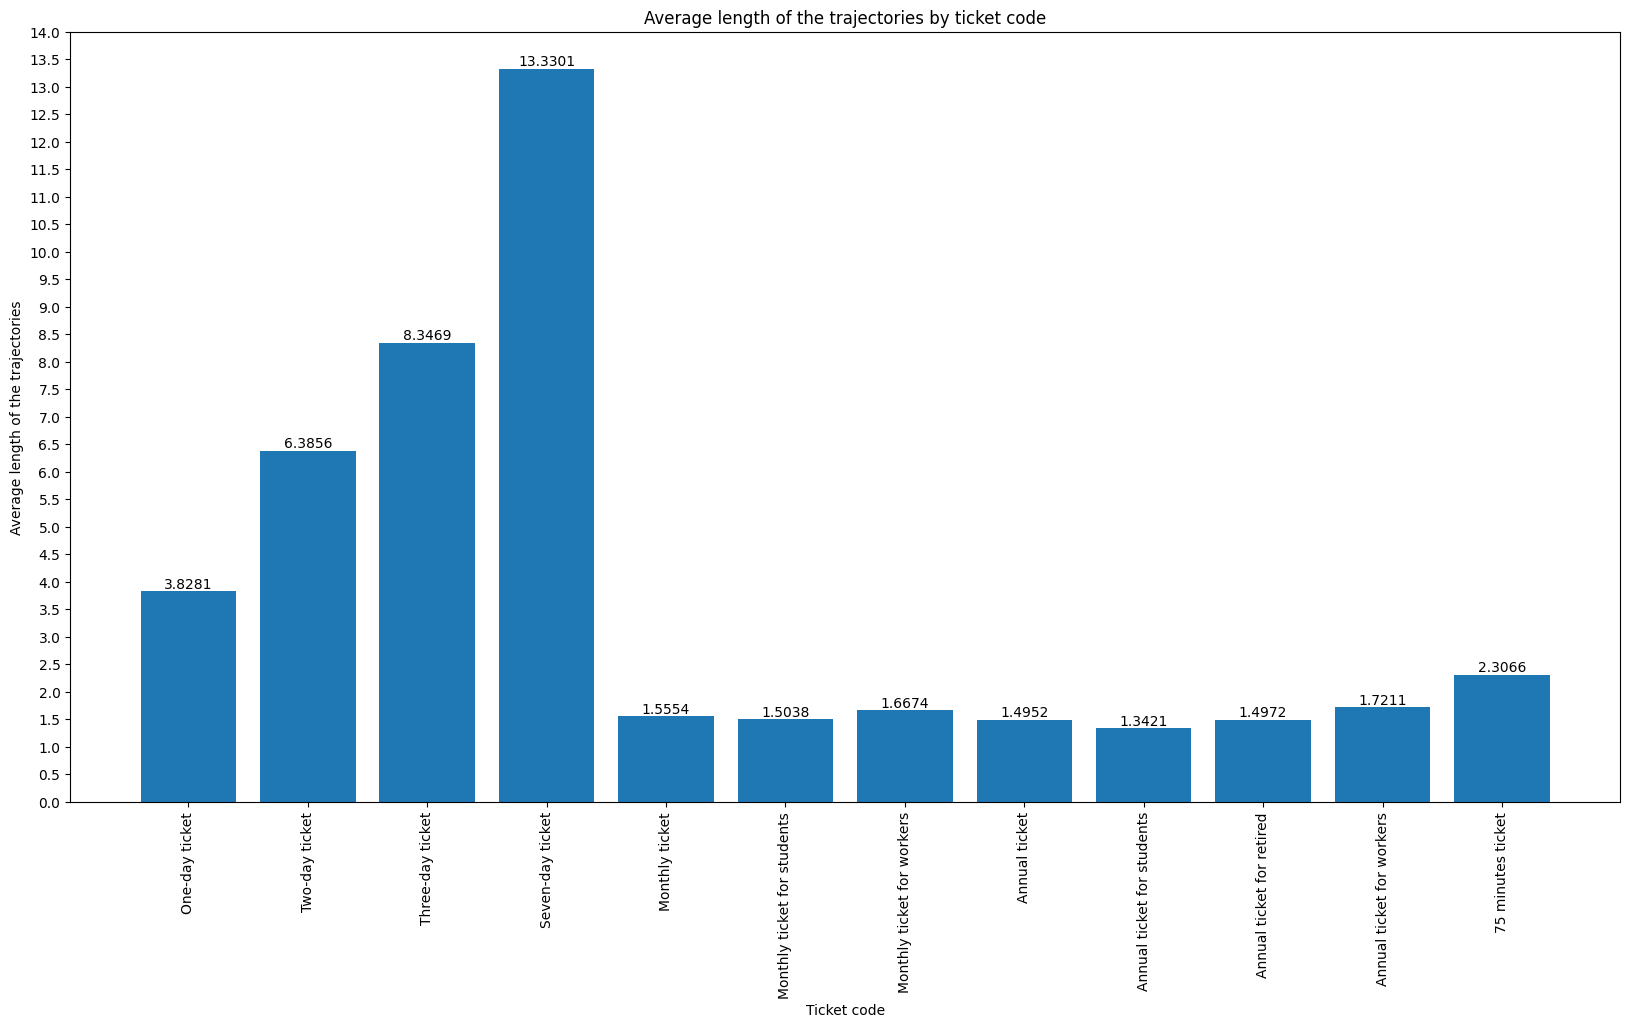

In [20]:
# Compute the average length of the trajectories
average_lenght = average_length_of_trajectories(dict_trajectories)
print('The average length of the trajectories considering all the dataframe is: {}'.format(average_lenght))
average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df)

### Compute the average length of the trajectories with the dataset with the ticket code 7

In [21]:
# # Create a dictionary with the trajectories of the users with the ticket code '7'
# df_sup = mf.focus_on_ticket_code(df,'7')
# # Create a dictionary with the trajectories of the users
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# # Compute the average length of the trajectories
# average_lenght = average_length_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='7')
# # average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df_sup, 'data/dictionaries/dict_ticket_codes.json')
# # trajectories_with_at_least_k_stations(dict_trajectories, 3)

### Print information for each ticket code

In [22]:
# For each ticket code:
# a. Create a dictionary with the trajectories of the users with the ticket code
# b. Compute the average length of the trajectories (number of stations visited)
# c. Compute the number of users 
# d. Compute the number of trajectories
# e. Find the most frequent trajectories

ticket_code = mf.open_dict_ticket_codes()

dict_trajectories = create_or_load_dictionary_with_trajectories(df)
# average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df, 'data/dictionaries/dict_ticket_codes.json')

for ticket_code in ticket_code.keys():
    # Exclude the ticket code '8' 
    if ticket_code == '8':
        continue
    
    print('Ticket code: {} - "{}"'.format(ticket_code, mf.get_ticket_code_description(ticket_code)))

    # a. Create a dictionary with the trajectories of the users with the ticket code
    df_sup = mf.focus_on_ticket_code(df, ticket_code)
    dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'tc:' + ticket_code)
    if len(dict_trajectories.keys()) == 0:
        print('\t No trajectories to analyze')
        print('')
        continue
    
    # b. Compute the average length of the trajectories (number of stations visited)
    avg_len_trj = average_length_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code)
    print('The average length of the trajectories is: {}'.format(avg_len_trj))
    
    # c. Compute the number of users (Seriale)
    number_of_users = len(dict_trajectories.keys()) # TODO: r u sure?
    
    # d. Compute the number of trajectories
    num_trj = number_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, summary=False)
    print('The number of trajectories is: {}'.format(num_trj))
    
    # e. Find the most frequent trajectories
    most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, k=5, summary=True, min_length=2)
    print('')

The folder already exists.
Ticket code: 1 - "One-day ticket"
The folder already exists.
The average length of the trajectories is: 3.8281
The number of trajectories is: 35375
The most 5 frequent trajectories with a minimum length of 2 stop(s) for the ticket code 1 - "One-day ticket" are:
	 [['F.TE NOVE', 'BURANO']] - 2668
	 [['F.TE NOVE', 'MURANO', 'BURANO']] - 2582
	 [['SAN MARCO', 'BURANO']] - 2124
	 [['F.TE NOVE', 'BURANO', 'MURANO']] - 1635
	 [['SAN MARCO', 'MURANO', 'BURANO']] - 1451

Ticket code: 2 - "Two-day ticket"
The folder already exists.
The average length of the trajectories is: 6.3856
The number of trajectories is: 26515
The most 5 frequent trajectories with a minimum length of 2 stop(s) for the ticket code 2 - "Two-day ticket" are:
	 [['FERROVIA', 'RIALTO']] - 217
	 [['FERROVIA', 'SAN MARCO']] - 115
	 [['P.LE ROMA', 'RIALTO']] - 106
	 [['PUNTA SABBIO', 'SAN MARCO', 'PUNTA SABBIO', 'SAN MARCO']] - 89
	 [['TRONCHETTO', 'RIALTO']] - 65

Ticket code: 3 - "Three-day ticket"
T

In [23]:
def print_trajectories_of_user(dict_trajectories: dict, user: str):
    """
        This function prints the trajectories of a user.
        :param dict_trajectories: the dictionary with the trajectories
        :param user: the user
    """
    # print the dataframes of the trajectories of the user
    df_aux = df[df['SERIALE'] == user]
    print(df_aux)

In [24]:
# Given the serial of a user, print the trajectories of the user
# Serial of the user of the first trajectory
serial = list(dict_trajectories.keys())[0][0]
# Print the trajectories of the user
print_trajectories_of_user(dict_trajectories, serial)

        DATA       ORA     DATA_VALIDAZIONE            SERIALE  FERMATA  \
0 2023-01-13  00:00:00  2023-01-13 00:00:00  40834866809772548      162   

    DESCRIZIONE  TITOLO TICKET_CODE           DESCRIZIONE_TITOLO  
0  STAZIONE MES   12101           7  BIGL.AUT.75'MESTRE/LIDO-TSC  


### Find the most frequent trajectories with the entire dataset

In [25]:
# Create a dictionary with the trajectories of the users with the entire dataset
dict_trajectories = create_or_load_dictionary_with_trajectories(df)
# Find the most frequent trajectories and print the summary
most_freq_trj = most_frequent_trajectories(dict_trajectories, k=20, summary=True, min_length=3)

The folder already exists.
The most 20 frequent trajectories with a minimum length of 3 stop(s) are:
	 [['F.TE NOVE', 'MURANO', 'BURANO']] - 2646
	 [['F.TE NOVE', 'BURANO', 'MURANO']] - 1703
	 [['SAN MARCO', 'MURANO', 'BURANO']] - 1501
	 [['FERROVIA', 'MURANO', 'BURANO']] - 1366
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA', 'RIALTO']] - 1203
	 [['P.LE ROMA', 'RIALTO', 'RIALTO']] - 1198
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA']] - 1071
	 [['P.LE ROMA', 'MURANO', 'BURANO']] - 1068
	 [['P.LE ROMA', 'RIALTO', 'VENEZIA']] - 975
	 [['RIALTO', 'P.LE ROMA', 'RIALTO']] - 721
	 [['P.LE ROMA', 'P.LE ROMA', 'RIALTO']] - 707
	 [['LIDO', 'LIDO', 'S. MARCO-SAN']] - 644
	 [['LIDO', 'S. MARCO-SAN', 'LIDO']] - 643
	 [['PUNTA SABBIO', 'SAN MARCO', 'PUNTA SABBIO', 'SAN MARCO']] - 634
	 [['FERROVIA', 'RIALTO', 'RIALTO']] - 579
	 [['SAN MARCO', 'BURANO', 'MURANO']] - 565
	 [['PUNTA SABBIO', 'LIDO', 'SAN MARCO']] - 501
	 [['F.TE NOVE', 'BURANO', 'RIALTO']] - 484
	 [['PUNTA SABBIO', 'LIDO', 'LIDO']] - 455
	 [['P.LE R

### Find the most frequent trajectories with the dataset with a specified ticket code

In [26]:
# Create a dictionary with the trajectories of the users with the ticket code '1'
ticket_code = '1'
df_sup = mf.focus_on_ticket_code(df, ticket_code)
# Create a dictionary with the trajectories of the users with the ticket code '1'
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name= file_name + '_' + 'tc:' + ticket_code)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1', summary=False, k = -1, min_length=4)

The folder already exists.


In [27]:
# Which are the common itineraries for tourists? 
# The tourist have the ticket code '1', '2', '3', '4'
# Create a dictionary with the trajectories of the users with the ticket code '1', '2', '3', '4'
df_sup = mf.focus_on_ticket_code_list(df,['1','2','3','4'])
# Create a dictionary with the trajectories of the users with the ticket code '1', '2', '3', '4'
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name= file_name + '_' + 'tourists')
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 10, min_length=4, summary=True)

The folder already exists.
The most 10 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['FERROVIA', 'RIALTO', 'FERROVIA', 'BURANO', 'FERROVIA', 'RIALTO', 'FERROVIA']] - 28
	 [['F.TE NOVE', 'MURANO', 'MURANO', 'BURANO']] - 25
	 [['FERROVIA', 'MURANO', 'BURANO', 'RIALTO']] - 25
	 [['FERROVIA', 'F.TE NOVE', 'BURANO', 'MURANO']] - 21
	 [['FERROVIA', 'F.TE NOVE', 'BURANO', 'RIALTO']] - 20
	 [['SAN MARCO', 'MURANO', 'MURANO', 'BURANO']] - 18
	 [['FERROVIA', 'MURANO', 'BURANO', 'MURANO']] - 17
	 [['F.TE NOVE', 'MURANO', 'BURANO', 'S. MARCO-SAN']] - 16
	 [['F.TE NOVE', 'MURANO', 'BURANO', 'RIALTO']] - 16
	 [['F.TE NOVE', 'MURANO', 'BURANO', 'SAN MARCO']] - 16


In [28]:
# Which are the common itineraries for not tourists?
# The not tourist have the ticket code different from '1', '2', '3', '4'
# Create a dictionary with the trajectories of the users with the ticket code different from '1', '2', '3', '4'
df_sup = mf.focus_on_ticket_code_list(df,['5', '5-WKRS', '5-STUD', '5-RET', '6', '6-WKRS', '6-STUD', '6-RET', '7'])
# Create a dictionary with the trajectories of the users with the ticket code different from '1', '2', '3', '4'
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'not_tourists')
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 10, min_length=4, summary=True)


The folder already exists.
The most 10 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA', 'RIALTO']] - 134
	 [['LIDO', 'S. MARCO-SAN', 'LIDO', 'S. MARCO-SAN']] - 31
	 [['PEOPLE MOVER', 'P.LE ROMA', 'RIALTO', 'PEOPLE MOVER']] - 26
	 [['RIALTO', 'P.LE ROMA', 'RIALTO', 'P.LE ROMA']] - 21
	 [['S. TOMA\' "B"', 'RIALTO', 'S. TOMA\' "B"', 'RIALTO']] - 21
	 [['S. ANGELO', 'S. TOMA\' "B"', 'S. ANGELO', 'S. TOMA\' "B"']] - 19
	 [['S. STAE', 'S. MARCUOLA-', 'S. STAE', 'S. MARCUOLA-']] - 16
	 [['S.ELENA-STAD', 'S. MARCO-SAN', 'S.ELENA-STAD', 'S. MARCO-SAN']] - 16
	 [['MESTRE', 'P.LE ROMA', 'RIALTO', 'VENEZIA']] - 15
	 [['P.LE ROMA', 'RIALTO', 'RIALTO', 'RIALTO']] - 14


In [29]:
# Which are the common itineraries for students?
# The students have the ticket code '5-STUD', '6-STUD'
# Create a dictionary with the trajectories of the users with the ticket code '5-STUD', '6-STUD'
df_sup = mf.focus_on_ticket_code_list(df,['5-STUD', '6-STUD'])
# Create a dictionary with the trajectories of the users with the ticket code '5-STUD', '6-STUD'
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'students')
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 10, min_length=4, summary=True)

The folder already exists.
The most 10 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA', 'RIALTO']] - 14
	 [['LIDO', 'BURANO', 'MURANO', 'P.LE ROMA']] - 6
	 [['LIDO', 'BURANO', 'MURANO', 'BURANO', 'P.LE ROMA']] - 4
	 [['SALUTE', 'GUGLIE', 'FERROVIA', 'RIALTO']] - 4
	 [['P.LE ROMA', 'RIALTO', 'FERROVIA', 'RIALTO']] - 3
	 [['PALEOCAPA PA', 'P.LE ROMA', 'RIALTO', 'VENEZIA']] - 3
	 [['S.ELENA-STAD', 'LIDO', 'S.ELENA-STAD', 'LIDO']] - 3
	 [['GALLO', 'LIDO', 'FERROVIA', 'SANTA MARIA ']] - 3
	 [['SAN MARCO', 'GIUDECCA PAL', 'P.LE ROMA', 'GIUDECCA PAL']] - 2
	 [['S. MARCO-SAN', 'LIDO', 'S. MARCO-SAN', 'LIDO']] - 2


In [30]:
# Which are the common itineraries for workers?
# The workers have the ticket code '5-WKRS', '6-WKRS'
# Create a dictionary with the trajectories of the users with the ticket code '5-WKRS', '6-WKRS'
df_sup = mf.focus_on_ticket_code_list(df,['5-WKRS', '6-WKRS'])
# Create a dictionary with the trajectories of the users with the ticket code '5-WKRS', '6-WKRS'
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'workers')
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 10, min_length=4, summary=True)

The folder already exists.
The most 10 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['PUNTA SABBIO', 'S. MARCO-SAN', 'S. TOMA\' "B"', 'SAN MARCO']] - 6
	 [['PUNTA SABBIO', 'LIDO', 'S. STAE', 'SAN MARCO']] - 3
	 [['PUNTA SABBIO', 'SAN MARCO', 'PUNTA SABBIO', 'LIDO', 'FERROVIA', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'TOSATTO', 'P.LE ROMA', 'LIDO']] - 1
	 [['PUNTA SABBIO', 'VENEZIA', 'TOSATTO', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'SAN MARCO', 'LIDO', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'SAN MARCO', 'GIUDECCA PAL', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'S. MARCO VAL', 'S. MARCUOLA-', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'GIUDECCA PAL', 'LIDO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'S. MARCO VAL', 'LIDO']] - 1


In [31]:
# Which are the common itineraries for retired?
# The retired have the ticket code '5-RET', '6-RET'
# Create a dictionary with the trajectories of the users with the ticket code '5-RET', '6-RET'
df_sup = mf.focus_on_ticket_code_list(df,['5-RET', '6-RET'])
# Create a dictionary with the trajectories of the users with the ticket code '5-RET', '6-RET'
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'retired')
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 10, min_length=4, summary=True)

The folder already exists.
The most 10 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['S. TOMA\' "B"', 'RIALTO', 'S. TOMA\' "B"', 'RIALTO']] - 5
	 [['PUNTA SABBIO', 'LIDO', 'GIUDECCA PAL', 'LIDO']] - 2
	 [['GIARDINI', 'RIALTO', 'ZATTERE', 'SAN PIETRO', 'MADONNA']] - 2
	 [['CA', 'CAPPUCCINA', 'MESTRE', 'CA']] - 1
	 [['TERRAGLIO', 'EINAUDI CAST', 'GARIBALDI', 'CARDUCCI']] - 1
	 [['CA', 'CA', 'SAN DONA', 'MESTRE']] - 1
	 [['DE NICOLA CH', 'DE NICOLA CH', 'SAN DONA', 'MESTRE']] - 1
	 [['MARTELLAGO', 'S. MARCO-SAN', 'GIARDINI', 'MESTRE']] - 1
	 [['SAN DONA', 'MESTRE', 'SALAMONIO MA', 'MESTRE', 'TRIESTINA']] - 1
	 [['ZATTERE', 'GIUDECCA PAL', 'P.LE ROMA', 'GIUDECCA PAL', 'RIALTO']] - 1


### Find the most frequent trajectories with the dataset with a specified ticket code


In [32]:
# # Create a dictionary with the trajectories of the users with the ticket code '1'
# df_sup = mf.focus_on_ticket_code(df,'1')
# # Create a dictionary with the trajectories of the users with the ticket code '1'
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# # Find the trajectories with at least 20 stations visited with the ticket code '1'
# trajectories_with_at_least_k_stations(dict_trajectories, 4)

### Longest Common Subsequence (LCS)

In [33]:
def longest_common_subsequence_of_two_trajectories (trajectory_1: list, trajectory_2: list) -> list:
    """
        This function computes the longest common subsequence of two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the longest common subsequence of the two trajectories
    """
    # Create the matrix
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for x in range(len(trajectory_1) + 1)]

    # Compute the LCS
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the LCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    lcs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            lcs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the LCS
    lcs.reverse()

    return lcs

In [34]:
def longest_common_subsequence (dict_trajectories: dict):
    """
        This function computes the longest common subsequence of the trajectories of the dictionary.
        :param dict_trajectories: the dictionary with the trajectories
        :return: the longest common subsequence
    """

    # Compute the longest common subsequence
    # The trajectories of the dictionary are the keys of the dictionary
    trajectories = list(dict_trajectories.keys())
    lcs = trajectories[0]
    for i in range(1, len(trajectories)):
        lcs = longest_common_subsequence_of_two_trajectories(lcs, trajectories[i])

In [35]:
def shortest_common_supersequence_of_two_trajectories (trajectory_1: list, trajectory_2: list) -> list:
    """
        This function computes the shortest common supersequence of two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the shortest common supersequence of the two trajectories
    """
    # Create the matrix
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for x in range(len(trajectory_1) + 1)]

    # Compute the SCS
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the SCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    scs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            scs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            scs.append(trajectory_1[i - 1])
            i -= 1
        else:
            scs.append(trajectory_2[j - 1])
            j -= 1

    # Add the remaining elements of trajectory_1
    while i > 0:
        scs.append(trajectory_1[i - 1])
        i -= 1

    # Add the remaining elements of trajectory_2
    while j > 0:
        scs.append(trajectory_2[j - 1])
        j -= 1

    # Reverse the SCS
    scs.reverse()

    return scs

In [36]:
def shortest_common_supersequence (dict_trajectories: dict) -> list:
    """
        This function computes the shortest common supersequence of the trajectories of the dictionary.
        :param dict_trajectories: the dictionary with the trajectories
        :return: the shortest common supersequence
    """

    # Compute the shortest common supersequence
    # The trajectories of the dictionary are the keys of the dictionary
    trajectories = list(dict_trajectories.keys())
    scs = trajectories[0]
    for i in range(1, len(trajectories)):
        scs = shortest_common_supersequence_of_two_trajectories(scs, trajectories[i])
    
    return scs

In [37]:
# # Find the Longest Common Subsequence (LCS) between two trajectories
# trajectory_1 = ['SAN MARCO', 'P.LE ROMA', 'RIALTO', 'PUNTA SABBIO', 'BURANO']
# trajectory_2 = ['SAN MARCO', 'P.LE ROMA', 'PUNTA SABBIO', 'BURANO']

# lcs = longest_common_subsequence(trajectory_1, trajectory_2)
# print('The Longest Common Subsequence (LCS) between the trajectories {} and {} is {}'.format(trajectory_1, trajectory_2, lcs))

In [38]:
# # Find the Longest Common Subsequence (LCS) between two trajectories
# # Trajectory 1 is the trajectory of the dataset with the ticket code 1
# # Trajectory 2 is the most frequent trajectory of the dataset with the ticket code 2
# df_sup = mf.focus_on_ticket_code(df,'1')
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# dict_trajectories_number = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1', summary=False)
# trajectory_1 = list(dict_trajectories_number.keys())[8]

# df_sup = mf.focus_on_ticket_code(df,'2')
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# dict_trajectories_number = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='2', summary=False)
# trajectory_2 = list(dict_trajectories_number.keys())[0]

# lcs = longest_common_subsequence(trajectory_1, trajectory_2)
# print('The Longest Common Subsequence (LCS) between the trajectory {} and the trajectory {} is {}'.format(trajectory_1, trajectory_2, lcs))

_____

In [39]:
def most_frequent_stations_visited_by_the_users (dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = "", summary: bool = False) -> dict:
    """
        This function finds the most frequent stations visited by the users.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function is focused on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :return: the dictionary with the most frequent stations visited by the users
    """
    # Create a dictionary with the most frequent stations visited by the users
    dict_stations = {}
    
    # For each trajectory
    for trajectory in dict_trajectories.keys():
        # For each station in the trajectory
        for station in dict_trajectories[trajectory]:
            # If the station is not in the dictionary, add it
            if station not in dict_stations.keys():
                dict_stations[station] = 1
            # If the station is in the dictionary, increment its value
            else:
                dict_stations[station] += 1

    # Sort the dictionary with the most frequent stations visited by the users
    dict_stations = {k: v for k, v in sorted(dict_stations.items(), key=lambda item: item[1], reverse=True)}

    # Print the summary
    if summary and is_focus_on_ticket_code:
        print('The most frequent stations visited by the users with the ticket code {} are:'.format(ticket_code))
        for station in dict_stations.keys():
            print('The station {} is visited {} times'.format(station, dict_stations[station]))
    elif summary:
        print('The most frequent stations visited by the users are:')
        for station in dict_stations.keys():
            print('The station {} is visited {} times'.format(station, dict_stations[station]))

    return dict_stations

## TIME

In [40]:
def get_trajectories_from_key(df: pd.DataFrame, key: tuple) -> pd.DataFrame:
    """
        This function returns the rows of the dataframe for the specified key.
        Note that the key is in the format (serial, day), where day can be None that means that the seriale doesn't change over the days.
        :param df: the dataframe
        :param dict_trajectories: the dictionary with the trajectories
        :param key: the key
        :return: the row of the dataframe
    """
    # If the day is None, return the dataframe with the trajectories of the user
    if key[1] == None:
        #print('The key is: {}'.format(key))
        return df[df['SERIALE'] == key[0]]
    # Otherwise, return the dataframe with the trajectories of the user in the specified day
    else:
        # Notice that the data in the dataframe is a string while the data in the key is a Timestamp
        #print('The key is: {}'.format(key))
        # Convert the data in the dataframe to a Timestamp
        df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d %H:%M:%S')
        return df[(df['SERIALE'] == key[0]) & (df['DATA'].dt.date == key[1])]

In [41]:
# Function: given a tupla (seriale, day) get the time of the trajectory
# Notice that the second element of the tupla can be None
def get_time_of_trajectory (tupla: tuple) -> list:
    """
        This function returns the time of a trajectory.
        :param tupla: the tuple with the trajectory
        :return: the time of the trajectory
    """
    # Given the tuple (seriale, day), get the time of the trajectory, retrieving the dataframe
    df_aux = df[(df['SERIALE'] == tupla[0]) & (df['DATA'] == tupla[1])]
    # Get the time of the trajectory
    time = df_aux['ORA'].tolist()
    # Return the time of the trajectory
    return time

In [42]:
# # create a tupla with the first trajectory of the dictionary
# tupla = list(dict_trajectories.keys())[0]

# print(tupla)

# df_new = get_trajectories_from_key(df, tupla)
# # df_new

# # Print type of the data
# # print(type(df_new['DATA'].iloc[0]))
# # print(type(tupla[1]))

In [43]:
# Analysis of the trajectories considering the time of the day
# Find if there are some peculiarities in the trajectories of the users in the morning, in the afternoon, in the evening, in the night and if there are some differences between the trajectories with different ticket codes

def get_time_of_the_day (time: str) -> str:
    """
        This function returns the time of the day given a time.
        :param time: the time
        :return: the time of the day
    """
    # Convert the time to a datetime object
    time = datetime.strptime(time, '%H:%M:%S').time()
    # Return the time of the day
    if time < datetime.strptime('06:00:00', '%H:%M:%S').time():
        return 'night'
    elif time < datetime.strptime('12:00:00', '%H:%M:%S').time():
        return 'morning'
    elif time < datetime.strptime('18:00:00', '%H:%M:%S').time():
        return 'afternoon'
    else:
        return 'evening'
    
def get_time_of_the_day_from_timestamp (timestamp: str) -> str:
    """
        This function returns the time of the day given a timestamp.
        The time of the day is computed considering the following intervals:
        - early morning: from 00:00:00 to 06:00:00
        - morning: from 06:00:00 to 12:00:00
        - afternoon: from 12:00:00 to 18:00:00
        - evening: from 18:00:00 to 21:00:00
        - night: from 21:00:00 to 00:00:00
        :param timestamp: the timestamp as a string
        :return: the time of the day as a string
    """
    # Convert the timestamp to a datetime object
    timestamp = datetime.strptime(timestamp, '%H:%M:%S')
    # Return the time of the day
    if timestamp.time() < datetime.strptime('06:00:00', '%H:%M:%S').time():
        return 'early morning'
    elif timestamp.time() < datetime.strptime('12:00:00', '%H:%M:%S').time():
        return 'morning'
    elif timestamp.time() < datetime.strptime('18:00:00', '%H:%M:%S').time():
        return 'afternoon'
    elif timestamp.time() < datetime.strptime('21:00:00', '%H:%M:%S').time():
        return 'evening'
    else:
        return 'night'
    
def get_time_of_the_day_from_timestamp_list (timestamp_list: list) -> list:
    """
        This function returns the time of the day given a list of timestamp.
        :param timestamp_list: the list of timestamp
        :return: the list of time of the day
    """
    # Create the list of time of the day
    time_of_the_day_list = []
    # For each timestamp
    for timestamp in timestamp_list:
        # Add the time of the day to the list
        time_of_the_day_list.append(get_time_of_the_day_from_timestamp(timestamp))
    # Return the list of time of the day
    return time_of_the_day_list

def analyze_trajectories_over_the_hours_of_the_day (dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = "", summary: bool = False) -> dict:
    """
        This function analyzes the trajectories over the hours of the day.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function is focused on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :return: the dictionary with the trajectories over the hours of the day
    """
    if is_focus_on_ticket_code:
        print('The trajectories of the users with the ticket code {} are analyzed over the hours of the day'.format(ticket_code))
    else:
        print('The trajectories of the users are analyzed over the hours of the day')

    # Create a dictionary with the trajectories over the hours of the day
    dict_trajectories_over_the_hours_of_the_day = {}
    # For each trajectory
    for trajectory in dict_trajectories.keys():
        # Get the time of the day of the trajectory
        # print(trajectory)
        df_aux = get_trajectories_from_key(df, trajectory)
        # Create a list with the timestamps of the trajectory
        timestamp_list = df_aux['ORA'].tolist()
        # Get the time of the day of the trajectory
        time_of_the_day = get_time_of_the_day_from_timestamp_list(timestamp_list)
        # If the time of the day is not in the dictionary, add it
        if str(time_of_the_day) not in dict_trajectories_over_the_hours_of_the_day.keys():
            dict_trajectories_over_the_hours_of_the_day[str(time_of_the_day)] = 1
        # If the time of the day is in the dictionary, increment the counter
        else:
            dict_trajectories_over_the_hours_of_the_day[str(time_of_the_day)] += 1

    # Sort the dictionary with the trajectories over the hours of the day
    dict_trajectories_over_the_hours_of_the_day = {k: v for k, v in sorted(dict_trajectories_over_the_hours_of_the_day.items(), key=lambda item: item[1], reverse=True)}

    # Print the summary
    if summary:
        print('The trajectories over the hours of the day are:')
        for time_of_the_day in dict_trajectories_over_the_hours_of_the_day.keys():
            print('The trajectories over the hours of the day {} are {} times'.format(time_of_the_day, dict_trajectories_over_the_hours_of_the_day[time_of_the_day]))

    return dict_trajectories_over_the_hours_of_the_day

# Function to analyze trajectories over the hours of the days
def analyze_trajectories_over_the_hours_of_the_day_by_ticket_code (dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = "", summary: bool = False) -> dict:
    """
        This function analyzes the trajectories over the hours of the day by ticket code.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function is focused on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :return: the dictionary with the trajectories over the hours of the day by ticket code
    """
    trj_hour_ticketcodes = {}
    # For each ticket code
    for ticket_code in ticket_code.keys():
        # If the ticket code is '8', continue
        if ticket_code == '8':
            continue
        # Create a dictionary with the trajectories of the users with the ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'tc:' + ticket_code)
        # Analyze the trajectories over the hours of the day
        trj_hour_ticketcodes[ticket_code] = analyze_trajectories_over_the_hours_of_the_day(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, summary=False)

    # Print the summary
    if summary:
        print('The trajectories over the hours of the day by ticket code are:')
        for ticket_code in trj_hour_ticketcodes.keys():
            print('The trajectories over the hours of the day by ticket code {} are:'.format(ticket_code))
            for time_of_the_day in trj_hour_ticketcodes[ticket_code].keys():
                print('The trajectories over the hours of the day {} are {} times'.format(time_of_the_day, trj_hour_ticketcodes[ticket_code][time_of_the_day]))

    return trj_hour_ticketcodes

# Function to analyze trajectories over the hours of the days
def analyze_trajectories_over_the_hours_of_the_day_by_ticket_code_plot (dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = "", summary: bool = False) -> dict:
    """
        This function plots the trajectories over the hours of the day by ticket code.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function is focused on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :return: the dictionary with the trajectories over the hours of the day by ticket code
    """
    trj_hour_ticketcodes = {}
    # For each ticket code
    for ticket_code in ticket_code:
        # If the ticket code is '8', continue
        if ticket_code == '8':
            continue
        # Create a dictionary with the trajectories of the users with the ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'tc:' + ticket_code)
        # Analyze the trajectories over the hours of the day
        trj_hour_ticketcodes[ticket_code] = analyze_trajectories_over_the_hours_of_the_day(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, summary=False)

    # Plot the trajectories over the hours of the day by ticket code
    fig, ax = plt.subplots()
    for ticket_code in trj_hour_ticketcodes.keys():
        x = list(trj_hour_ticketcodes[ticket_code].keys())
        y = list(trj_hour_ticketcodes[ticket_code].values())
        ax.plot(x, y, label=ticket_code)
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Number of trajectories')
    ax.set_title('Trajectories over the hours of the day by ticket code')
    ax.legend()
    plt.show()

    return trj_hour_ticketcodes

In [44]:
# Dict with the trajectories only with the ticket code '1'
df_sup = mf.focus_on_ticket_code(df,'1')
dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'tc:' + '1')

# Select only a part of the dictionary
dict_trajectories = dict(list(dict_trajectories.items())[0:100])

The folder already exists.


In [45]:
# Call the function to analyze the trajectories over the hours of the day
analyze_trajectories_over_the_hours_of_the_day(dict_trajectories, summary=True)

The trajectories of the users are analyzed over the hours of the day
The trajectories over the hours of the day are:
The trajectories over the hours of the day ['morning'] are 27 times
The trajectories over the hours of the day ['early morning'] are 15 times
The trajectories over the hours of the day ['morning', 'morning'] are 6 times
The trajectories over the hours of the day ['morning', 'afternoon', 'afternoon'] are 4 times
The trajectories over the hours of the day ['morning', 'morning', 'morning', 'morning', 'morning', 'afternoon', 'afternoon', 'evening', 'evening'] are 4 times
The trajectories over the hours of the day ['morning', 'morning', 'morning', 'afternoon'] are 3 times
The trajectories over the hours of the day ['morning', 'morning', 'morning', 'afternoon', 'afternoon', 'afternoon', 'evening'] are 3 times
The trajectories over the hours of the day ['early morning', 'morning', 'afternoon', 'evening', 'evening'] are 2 times
The trajectories over the hours of the day ['early 

{"['morning']": 27,
 "['early morning']": 15,
 "['morning', 'morning']": 6,
 "['morning', 'afternoon', 'afternoon']": 4,
 "['morning', 'morning', 'morning', 'morning', 'morning', 'afternoon', 'afternoon', 'evening', 'evening']": 4,
 "['morning', 'morning', 'morning', 'afternoon']": 3,
 "['morning', 'morning', 'morning', 'afternoon', 'afternoon', 'afternoon', 'evening']": 3,
 "['early morning', 'morning', 'afternoon', 'evening', 'evening']": 2,
 "['early morning', 'morning', 'morning', 'afternoon']": 2,
 "['early morning', 'morning', 'afternoon', 'afternoon', 'afternoon']": 2,
 "['morning', 'morning', 'morning', 'morning', 'afternoon', 'afternoon']": 2,
 "['morning', 'morning', 'morning', 'morning', 'afternoon', 'afternoon', 'evening']": 2,
 "['morning', 'morning', 'afternoon', 'afternoon', 'evening', 'night']": 2,
 "['morning', 'morning', 'afternoon', 'afternoon', 'afternoon']": 2,
 "['morning', 'morning', 'morning', 'morning', 'afternoon', 'afternoon', 'evening', 'evening']": 2,
 "['m

In [46]:
# Check if the trajectories that start in the morning end in the evening or in the night and vice versa
# Create a dictionary with the trajectories that start in the morning and end in the evening or in the night
dict_trajectories_morning_evening_night = {}
# For each trajectory
for trajectory in dict_trajectories.keys():
    # Get the time of the day of the trajectory
    df_aux = get_trajectories_from_key(df, trajectory)
    # Create a list with the timestamps of the trajectory
    timestamp_list = df_aux['ORA'].tolist()
    # Get the time of the day of the trajectory
    time_of_the_day = get_time_of_the_day_from_timestamp_list(timestamp_list)
    # If the trajectory starts in the morning and ends in the evening or in the night, add it to the dictionary
    if time_of_the_day[0] == 'morning' and (time_of_the_day[-1] == 'evening' or time_of_the_day[-1] == 'night'):
        dict_trajectories_morning_evening_night[trajectory] = dict_trajectories[trajectory]

# Print the summary
print('The trajectories that start in the morning and end in the evening or in the night are:')
for trajectory in dict_trajectories_morning_evening_night.keys():
    print('The trajectory {} starts in the morning and ends in the evening or in the night'.format(trajectory))

The trajectories that start in the morning and end in the evening or in the night are:
The trajectory (41677373358790404, None) starts in the morning and ends in the evening or in the night
The trajectory (41677373358782980, None) starts in the morning and ends in the evening or in the night
The trajectory (41677373358786564, None) starts in the morning and ends in the evening or in the night
The trajectory (41677373358786308, None) starts in the morning and ends in the evening or in the night
The trajectory (40834232622848516, None) starts in the morning and ends in the evening or in the night
The trajectory (41677373356862212, None) starts in the morning and ends in the evening or in the night
The trajectory (41677373358782724, None) starts in the morning and ends in the evening or in the night
The trajectory (41677373358779396, None) starts in the morning and ends in the evening or in the night
The trajectory (41678161619024132, None) starts in the morning and ends in the evening or

In [47]:
# Function that considers the trajectories with at least 2 stations visited and analyzes the trajectories over the hours of the day
# Plot them using the ticket code
def analyze_trajectories_over_the_hours_of_the_day_by_ticket_code_plot (dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = "", summary: bool = False) -> dict:
    """
        This function plots the trajectories over the hours of the day by ticket code.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function is focused on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :return: the dictionary with the trajectories over the hours of the day by ticket code
    """
    # Get ticket code
    ticket_code = list(df['TICKET_CODE'].unique())

    trj_hour_ticketcodes = {}
    # For each ticket code
    for ticket_code in ticket_code:
        print('The ticket code is: {}'.format(ticket_code))
        # If the ticket code is '8', continue
        if ticket_code == '8':
            continue
        # Create a dictionary with the trajectories of the users with the ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        # Select only the first 100 trajectories
        df_sup = df_sup.head(30)
        dict_trajectories = create_or_load_dictionary_with_trajectories(df_sup, file_name = file_name + '_' + 'tc:' + ticket_code)
        # Analyze the trajectories over the hours of the day
        trj_hour_ticketcodes[ticket_code] = analyze_trajectories_over_the_hours_of_the_day(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, summary=False)

    # Plot the trajectories over the hours of the day by ticket code
    fig, ax = plt.subplots()
    for ticket_code in ticket_code:
        # If the ticket code is '8', continue
        if ticket_code == '8':
            continue
        x = list(trj_hour_ticketcodes[ticket_code].keys())
        y = list(trj_hour_ticketcodes[ticket_code].values())
        ax.plot(x, y, label=ticket_code)
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Number of trajectories')
    ax.set_title('Trajectories over the hours of the day by ticket code')
    ax.legend()
    plt.show()

    return trj_hour_ticketcodes

analyze_trajectories_over_the_hours_of_the_day_by_ticket_code_plot(dict_trajectories, summary=True)


The ticket code is: 7
The folder already exists.
The trajectories of the users with the ticket code 7 are analyzed over the hours of the day
The ticket code is: 5-STUD
The folder already exists.
The trajectories of the users with the ticket code 5-STUD are analyzed over the hours of the day


KeyboardInterrupt: 